In [1]:
# Histogram equalization of images
# Transfer learning or not
# Use all images or use them in pairs
# Create disparity map first?
# Blend the the two images for the third input channel?

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
path_img = Path('../image-data/stereo_camera_test-gray/stereo_camera_left')
path_lbl = Path('../image-data/stereo_camera_test-gray-annot/stereo_camera_left')

In [5]:
fnames_img = get_image_files(path_img)
fnames_img[:3]

[PosixPath('../image-data/stereo_camera_test-gray/stereo_camera_left/default_left(1)-0215.png'),
 PosixPath('../image-data/stereo_camera_test-gray/stereo_camera_left/default_left(1)-0447.png'),
 PosixPath('../image-data/stereo_camera_test-gray/stereo_camera_left/default_left(1)-0688.png')]

In [6]:
fnames_lbl = get_image_files(path_lbl)
fnames_lbl[:3]

[PosixPath('../image-data/stereo_camera_test-gray-annot/stereo_camera_left/default_left(1)-0215.png'),
 PosixPath('../image-data/stereo_camera_test-gray-annot/stereo_camera_left/default_left(1)-0447.png'),
 PosixPath('../image-data/stereo_camera_test-gray-annot/stereo_camera_left/default_left(1)-0688.png')]

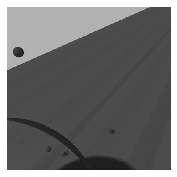

In [7]:
img_filename = fnames_img[0]
img = open_image(img_filename)
img.show()

In [8]:
get_y_fn = lambda x: path_lbl / x.name

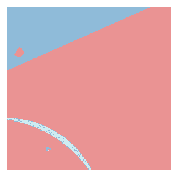

In [9]:
mask = open_mask(get_y_fn(img_filename))
mask.show()

In [10]:
codes = ('Background', 'High', 'Low', 'Medium')

In [11]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 24080MB of GPU RAM free


In [12]:
src_size = np.array(mask.shape[1:])
src_size, mask.data.shape

(array([400, 400]), torch.Size([1, 400, 400]))

In [13]:
# size = src_size // 2
size = src_size

data = (SegmentationItemList.from_folder(path_img)
      .split_by_rand_pct()
      .label_from_func(get_y_fn, classes=codes)
      .transform(get_transforms(), tfm_y=True, size=size)
      .databunch(bs=bs))

In [14]:
data.classes

('Background', 'High', 'Low', 'Medium')

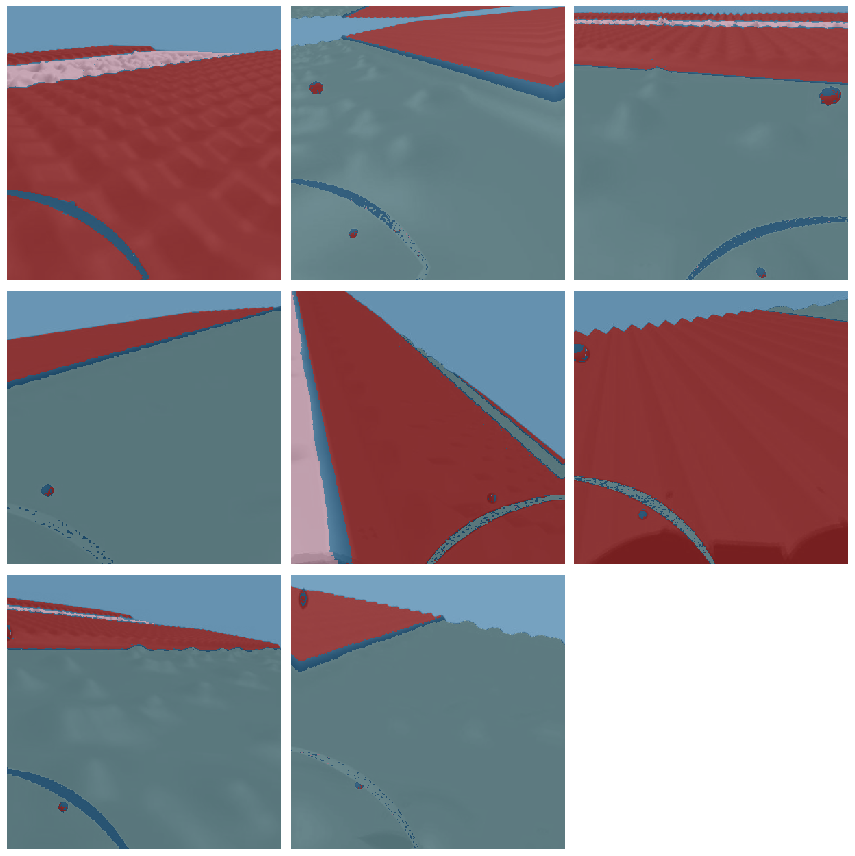

In [15]:
data.show_batch()

In [16]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Background']

def acc_stereo(input_img, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input_img.argmax(dim=1)[mask]==target[mask]).float().mean()

In [17]:
metrics = acc_stereo

In [18]:
wd = 1e-2

In [19]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
# learn = unet_learner(data, models.resnet34, wd=wd)

In [20]:
# lr_find(learn)
# learn.recorder.plot()

In [21]:
lr = 3e-3
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_stereo,time
0,0.410810,0.236066,0.948832,01:36
1,0.435841,0.202258,0.954906,01:22
2,0.475185,1.814818,0.615942,01:21
3,0.346216,0.129047,0.968585,01:21
4,0.392098,0.171127,0.958899,01:21
5,0.315848,0.134040,0.965186,01:21
6,0.340050,0.231220,0.911110,01:20
7,0.253577,0.103393,0.968581,01:20
8,0.176393,0.100161,0.974393,01:20
9,0.146829,0.068713,0.977386,01:20


In [24]:
learn.save('stage-1')

In [26]:
learn.load('stage-1');

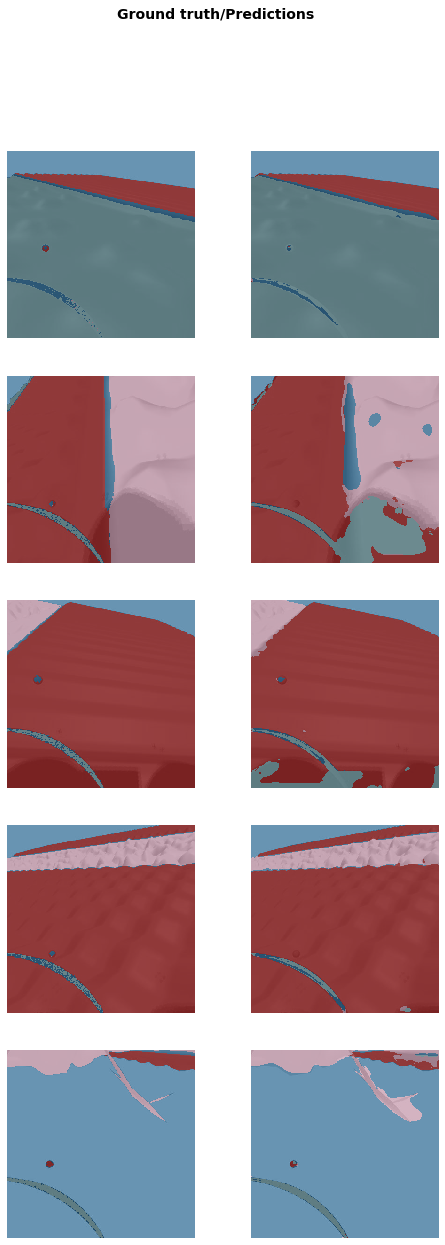

In [27]:
learn.show_results()

In [23]:
doc(learn.show_results)